## Self Supervised Learning by Convolutional Auto-Encoder with Random Images

Train Convolutional Auto-Encoder with Random Images

In [132]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch import rand, randn

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [133]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
        #     nn.Linear(3 * 3 * 32, 128),
        #     nn.ReLU(True),
        #     nn.Linear(128, encoded_space_dim)
            nn.Linear(14 * 14 * 8, encoded_space_dim) 
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
#        print(x.shape)
        x = self.flatten(x)
#        print(x.shape)
        x = self.encoder_lin(x)
#        print(x.shape)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            # nn.Linear(encoded_space_dim, 128),
            # nn.ReLU(True),
            # nn.Linear(128, 3 * 3 * 32),
            nn.Linear(encoded_space_dim, 14 * 14 * 8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(8, 14, 14))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 1, 3, stride=1, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
#        print(x.shape)
        x = self.unflatten(x)
#        print(x.shape)
        x = self.decoder_conv(x)
#        print(x.shape)
        # x = torch.sigmoid(x)
        return x

In [134]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 100

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=100, out_features=1568, bias=True)
    (1): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(8, 14, 14))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [135]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_batch = rand((255, 1, 28, 28))
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
#        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [136]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = rand((255, 1, 28, 28))
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [137]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      # img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      img = rand((1, 1, 28, 28)).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

EPOCH 1/200 	 train loss 0.09747113287448883 	 val loss 0.08348798751831055
EPOCH 2/200 	 train loss 0.0830610990524292 	 val loss 0.0823933482170105
EPOCH 3/200 	 train loss 0.08138182014226913 	 val loss 0.08005902916193008
EPOCH 4/200 	 train loss 0.07883801311254501 	 val loss 0.07766739279031754
EPOCH 5/200 	 train loss 0.07662944495677948 	 val loss 0.07603452354669571
EPOCH 6/200 	 train loss 0.07505371421575546 	 val loss 0.07438432425260544
EPOCH 7/200 	 train loss 0.07414033263921738 	 val loss 0.07376649975776672
EPOCH 8/200 	 train loss 0.07369716465473175 	 val loss 0.07344100624322891
EPOCH 9/200 	 train loss 0.07346884906291962 	 val loss 0.07343962788581848
EPOCH 10/200 	 train loss 0.07337527722120285 	 val loss 0.07328351587057114


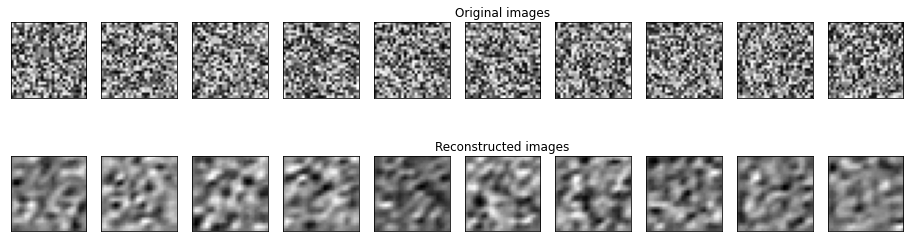

EPOCH 11/200 	 train loss 0.07331806421279907 	 val loss 0.07454503327608109
EPOCH 12/200 	 train loss 0.07329566031694412 	 val loss 0.07323569804430008
EPOCH 13/200 	 train loss 0.07321473956108093 	 val loss 0.07317785173654556
EPOCH 14/200 	 train loss 0.07318466156721115 	 val loss 0.07374156266450882
EPOCH 15/200 	 train loss 0.07321268320083618 	 val loss 0.0730762630701065
EPOCH 16/200 	 train loss 0.0731886550784111 	 val loss 0.0730900838971138
EPOCH 17/200 	 train loss 0.07315482944250107 	 val loss 0.07314924150705338
EPOCH 18/200 	 train loss 0.07315631210803986 	 val loss 0.07337945699691772
EPOCH 19/200 	 train loss 0.07530201226472855 	 val loss 0.0747077614068985
EPOCH 20/200 	 train loss 0.07341387867927551 	 val loss 0.07320059835910797


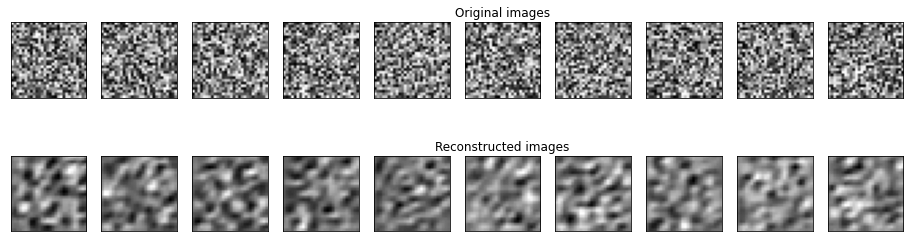

EPOCH 21/200 	 train loss 0.07305018603801727 	 val loss 0.07298628985881805
EPOCH 22/200 	 train loss 0.07296857237815857 	 val loss 0.07297733426094055
EPOCH 23/200 	 train loss 0.07295187562704086 	 val loss 0.07299923896789551
EPOCH 24/200 	 train loss 0.07296732813119888 	 val loss 0.0730469822883606
EPOCH 25/200 	 train loss 0.07297820597887039 	 val loss 0.07297860831022263
EPOCH 26/200 	 train loss 0.07301566749811172 	 val loss 0.07396560162305832
EPOCH 27/200 	 train loss 0.0730200707912445 	 val loss 0.07312123477458954
EPOCH 28/200 	 train loss 0.07303217798471451 	 val loss 0.07298412919044495
EPOCH 29/200 	 train loss 0.07304352521896362 	 val loss 0.0731450617313385
EPOCH 30/200 	 train loss 0.0730564221739769 	 val loss 0.07295668870210648


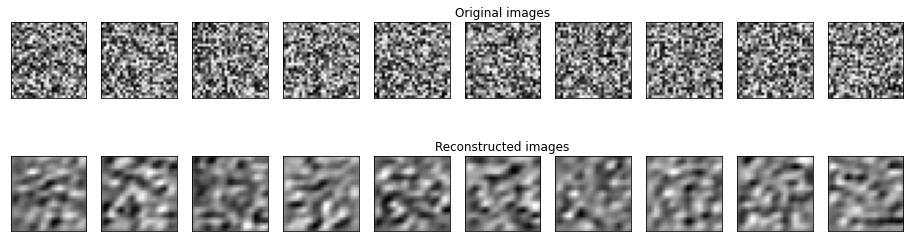

EPOCH 31/200 	 train loss 0.07300005853176117 	 val loss 0.07298459857702255
EPOCH 32/200 	 train loss 0.07298780232667923 	 val loss 0.07297426462173462
EPOCH 33/200 	 train loss 0.07740311324596405 	 val loss 0.0734996348619461
EPOCH 34/200 	 train loss 0.07327508181333542 	 val loss 0.07311511784791946
EPOCH 35/200 	 train loss 0.07308351248502731 	 val loss 0.07323039323091507
EPOCH 36/200 	 train loss 0.07299069315195084 	 val loss 0.07301872968673706
EPOCH 37/200 	 train loss 0.07292549312114716 	 val loss 0.07292405515909195
EPOCH 38/200 	 train loss 0.07295634597539902 	 val loss 0.07289313524961472
EPOCH 39/200 	 train loss 0.07292328774929047 	 val loss 0.07293659448623657
EPOCH 40/200 	 train loss 0.07290806621313095 	 val loss 0.07293655723333359


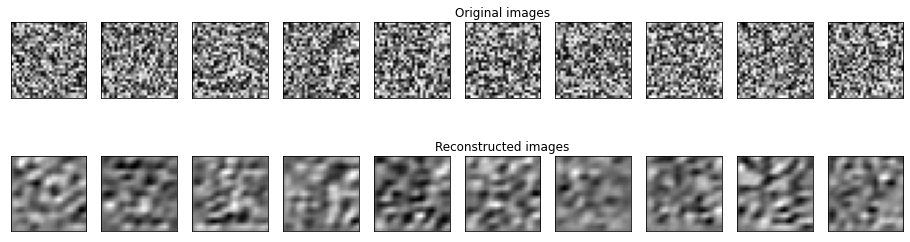

EPOCH 41/200 	 train loss 0.07294820994138718 	 val loss 0.0729379877448082
EPOCH 42/200 	 train loss 0.07296303659677505 	 val loss 0.07287344336509705
EPOCH 43/200 	 train loss 0.0729491338133812 	 val loss 0.07289976626634598
EPOCH 44/200 	 train loss 0.07295513898134232 	 val loss 0.07292060554027557
EPOCH 45/200 	 train loss 0.07290846109390259 	 val loss 0.07286794483661652
EPOCH 46/200 	 train loss 0.07292570173740387 	 val loss 0.07297397404909134
EPOCH 47/200 	 train loss 0.0729956105351448 	 val loss 0.07309062778949738
EPOCH 48/200 	 train loss 0.07293538004159927 	 val loss 0.07309070974588394
EPOCH 49/200 	 train loss 0.07293132692575455 	 val loss 0.07294350117444992
EPOCH 50/200 	 train loss 0.07293875515460968 	 val loss 0.07291456311941147


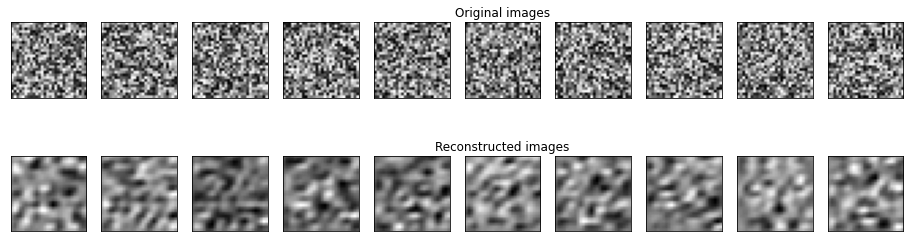

EPOCH 51/200 	 train loss 0.07293425500392914 	 val loss 0.07302475720643997
EPOCH 52/200 	 train loss 0.0729324147105217 	 val loss 0.07300785183906555
EPOCH 53/200 	 train loss 0.0729791596531868 	 val loss 0.07292243093252182
EPOCH 54/200 	 train loss 0.07294441759586334 	 val loss 0.07297524064779282
EPOCH 55/200 	 train loss 0.0729457437992096 	 val loss 0.07290652394294739
EPOCH 56/200 	 train loss 0.07298192381858826 	 val loss 0.0729251280426979
EPOCH 57/200 	 train loss 0.07293495535850525 	 val loss 0.07290410995483398
EPOCH 58/200 	 train loss 0.07297088950872421 	 val loss 0.07293272018432617
EPOCH 59/200 	 train loss 0.07295989990234375 	 val loss 0.07297232747077942
EPOCH 60/200 	 train loss 0.07292650640010834 	 val loss 0.07292117178440094


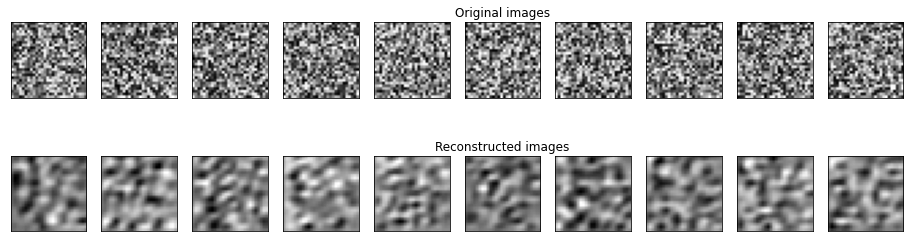

EPOCH 61/200 	 train loss 0.07341615110635757 	 val loss 0.13013175129890442
EPOCH 62/200 	 train loss 0.07695407420396805 	 val loss 0.07344874739646912
EPOCH 63/200 	 train loss 0.07320418953895569 	 val loss 0.07308030873537064
EPOCH 64/200 	 train loss 0.07297450304031372 	 val loss 0.0729292705655098
EPOCH 65/200 	 train loss 0.0729384496808052 	 val loss 0.07288578897714615
EPOCH 66/200 	 train loss 0.0729244276881218 	 val loss 0.07284469157457352
EPOCH 67/200 	 train loss 0.0729055181145668 	 val loss 0.07291153073310852
EPOCH 68/200 	 train loss 0.07289490103721619 	 val loss 0.0729067251086235
EPOCH 69/200 	 train loss 0.07289014756679535 	 val loss 0.07289452850818634
EPOCH 70/200 	 train loss 0.07289506494998932 	 val loss 0.07290289551019669


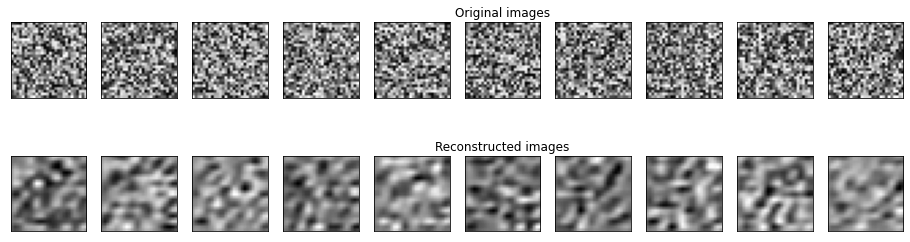

EPOCH 71/200 	 train loss 0.07287383824586868 	 val loss 0.07287755608558655
EPOCH 72/200 	 train loss 0.07289664447307587 	 val loss 0.07297296822071075
EPOCH 73/200 	 train loss 0.0729067474603653 	 val loss 0.07282883673906326
EPOCH 74/200 	 train loss 0.07291516661643982 	 val loss 0.07290022075176239
EPOCH 75/200 	 train loss 0.07291729003190994 	 val loss 0.07292158901691437
EPOCH 76/200 	 train loss 0.07292120158672333 	 val loss 0.07289515435695648
EPOCH 77/200 	 train loss 0.0729140192270279 	 val loss 0.07294702529907227
EPOCH 78/200 	 train loss 0.0729125589132309 	 val loss 0.07296398282051086
EPOCH 79/200 	 train loss 0.0729362815618515 	 val loss 0.07290928065776825
EPOCH 80/200 	 train loss 0.07292630523443222 	 val loss 0.07297105342149734


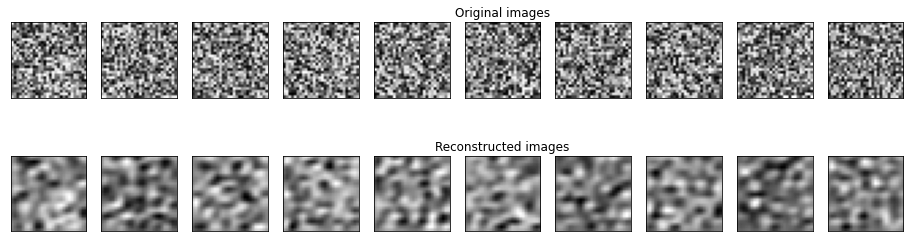

EPOCH 81/200 	 train loss 0.07294795662164688 	 val loss 0.07295611500740051
EPOCH 82/200 	 train loss 0.07294072955846786 	 val loss 0.07294098287820816
EPOCH 83/200 	 train loss 0.07293082028627396 	 val loss 0.07296235114336014
EPOCH 84/200 	 train loss 0.07294660806655884 	 val loss 0.07290101051330566
EPOCH 85/200 	 train loss 0.07295484840869904 	 val loss 0.07296545803546906
EPOCH 86/200 	 train loss 0.07294318079948425 	 val loss 0.07293040305376053
EPOCH 87/200 	 train loss 0.07293391227722168 	 val loss 0.07287266105413437
EPOCH 88/200 	 train loss 0.07294989377260208 	 val loss 0.07296397536993027
EPOCH 89/200 	 train loss 0.07294944673776627 	 val loss 0.07296280562877655
EPOCH 90/200 	 train loss 0.07293449342250824 	 val loss 0.07294631004333496


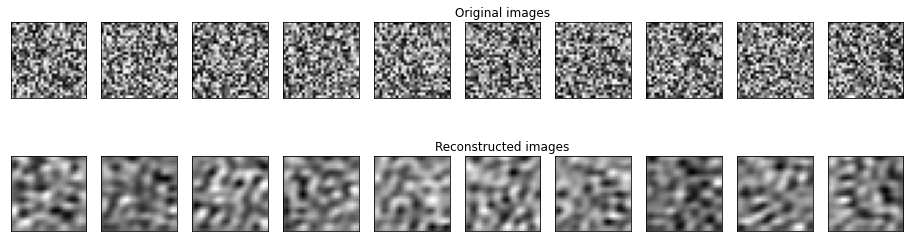

EPOCH 91/200 	 train loss 0.07295340299606323 	 val loss 0.07296158373355865
EPOCH 92/200 	 train loss 0.07292824238538742 	 val loss 0.07297752052545547
EPOCH 93/200 	 train loss 0.07293408364057541 	 val loss 0.07295798510313034
EPOCH 94/200 	 train loss 0.07295378297567368 	 val loss 0.07290901243686676
EPOCH 95/200 	 train loss 0.07297877222299576 	 val loss 0.07293755561113358
EPOCH 96/200 	 train loss 0.07297375798225403 	 val loss 0.07286625355482101
EPOCH 97/200 	 train loss 0.07295061647891998 	 val loss 0.07295878231525421
EPOCH 98/200 	 train loss 0.07295829802751541 	 val loss 0.07297448068857193
EPOCH 99/200 	 train loss 0.07295826822519302 	 val loss 0.07292579859495163
EPOCH 100/200 	 train loss 0.07294271141290665 	 val loss 0.07290395349264145


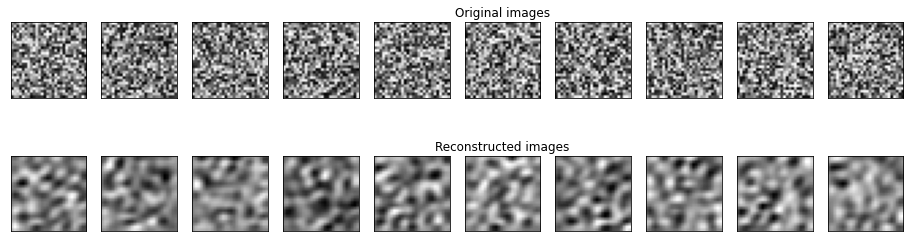

EPOCH 101/200 	 train loss 0.07294196635484695 	 val loss 0.07295525074005127
EPOCH 102/200 	 train loss 0.0729600191116333 	 val loss 0.07297638058662415
EPOCH 103/200 	 train loss 0.07294009625911713 	 val loss 0.07297543436288834
EPOCH 104/200 	 train loss 0.07294990867376328 	 val loss 0.07294447720050812
EPOCH 105/200 	 train loss 0.0729488730430603 	 val loss 0.07294008135795593
EPOCH 106/200 	 train loss 0.07295271009206772 	 val loss 0.07289142161607742
EPOCH 107/200 	 train loss 0.0729408785700798 	 val loss 0.0729464441537857
EPOCH 108/200 	 train loss 0.07294478267431259 	 val loss 0.07302390038967133
EPOCH 109/200 	 train loss 0.07293905317783356 	 val loss 0.07294360548257828
EPOCH 110/200 	 train loss 0.07293881475925446 	 val loss 0.07299551367759705


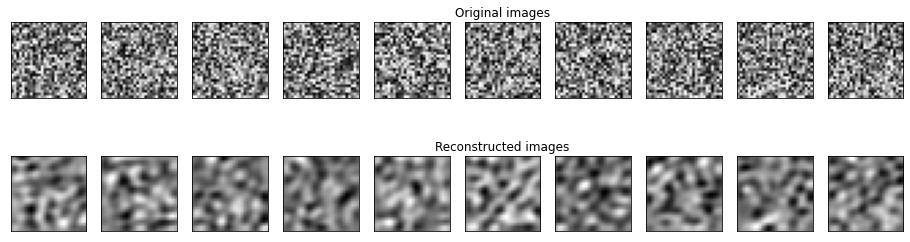

EPOCH 111/200 	 train loss 0.07293111085891724 	 val loss 0.07297132909297943
EPOCH 112/200 	 train loss 0.07292383909225464 	 val loss 0.07294853776693344
EPOCH 113/200 	 train loss 0.07294674962759018 	 val loss 0.07288246601819992
EPOCH 114/200 	 train loss 0.07294408977031708 	 val loss 0.0729423388838768
EPOCH 115/200 	 train loss 0.07294635474681854 	 val loss 0.07295487076044083
EPOCH 116/200 	 train loss 0.0729256197810173 	 val loss 0.07291022688150406
EPOCH 117/200 	 train loss 0.07293713092803955 	 val loss 0.0729123055934906
EPOCH 118/200 	 train loss 0.07295116782188416 	 val loss 0.07292425632476807
EPOCH 119/200 	 train loss 0.07293875515460968 	 val loss 0.0729622170329094
EPOCH 120/200 	 train loss 0.07293426245450974 	 val loss 0.07291020452976227


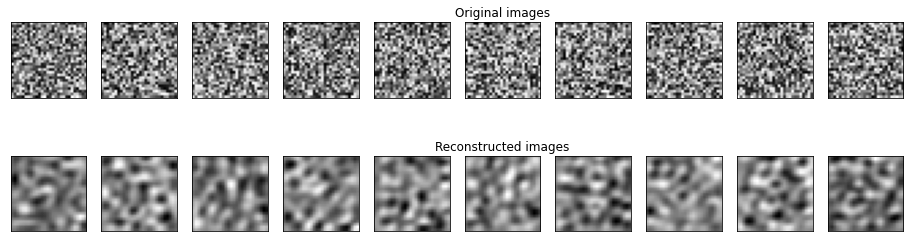

EPOCH 121/200 	 train loss 0.072915218770504 	 val loss 0.07296878844499588
EPOCH 122/200 	 train loss 0.07294262200593948 	 val loss 0.07291550189256668
EPOCH 123/200 	 train loss 0.0729491338133812 	 val loss 0.07295140624046326
EPOCH 124/200 	 train loss 0.07293933629989624 	 val loss 0.07294115424156189
EPOCH 125/200 	 train loss 0.0729459673166275 	 val loss 0.07291217893362045
EPOCH 126/200 	 train loss 0.07293043285608292 	 val loss 0.07294749468564987
EPOCH 127/200 	 train loss 0.0729341134428978 	 val loss 0.07289009541273117
EPOCH 128/200 	 train loss 0.07293011993169785 	 val loss 0.07292589545249939
EPOCH 129/200 	 train loss 0.0729227289557457 	 val loss 0.0729111060500145
EPOCH 130/200 	 train loss 0.0729413852095604 	 val loss 0.07289502024650574


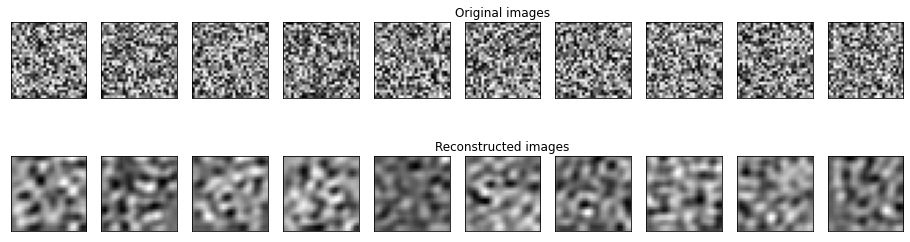

EPOCH 131/200 	 train loss 0.07291356474161148 	 val loss 0.07290323823690414
EPOCH 132/200 	 train loss 0.07292604446411133 	 val loss 0.07296128571033478
EPOCH 133/200 	 train loss 0.0729471892118454 	 val loss 0.07308662682771683
EPOCH 134/200 	 train loss 0.07293514907360077 	 val loss 0.07292823493480682
EPOCH 135/200 	 train loss 0.07294609397649765 	 val loss 0.07298668473958969
EPOCH 136/200 	 train loss 0.07294812798500061 	 val loss 0.07292550802230835
EPOCH 137/200 	 train loss 0.07293485850095749 	 val loss 0.07292772084474564
EPOCH 138/200 	 train loss 0.07293771207332611 	 val loss 0.0729229673743248
EPOCH 139/200 	 train loss 0.07294196635484695 	 val loss 0.07293006777763367
EPOCH 140/200 	 train loss 0.07293813675642014 	 val loss 0.07294446229934692


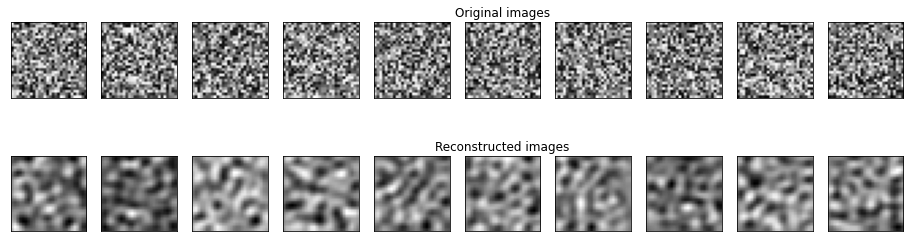

EPOCH 141/200 	 train loss 0.07293575257062912 	 val loss 0.07298164814710617
EPOCH 142/200 	 train loss 0.07295195758342743 	 val loss 0.07295441627502441
EPOCH 143/200 	 train loss 0.07293836027383804 	 val loss 0.07298101484775543
EPOCH 144/200 	 train loss 0.07292307913303375 	 val loss 0.0729297399520874
EPOCH 145/200 	 train loss 0.07294031232595444 	 val loss 0.07293042540550232
EPOCH 146/200 	 train loss 0.07292554527521133 	 val loss 0.07292933762073517
EPOCH 147/200 	 train loss 0.07293205708265305 	 val loss 0.07287369668483734
EPOCH 148/200 	 train loss 0.0729217529296875 	 val loss 0.07294435799121857
EPOCH 149/200 	 train loss 0.07292632758617401 	 val loss 0.07291404902935028
EPOCH 150/200 	 train loss 0.07292735576629639 	 val loss 0.0729348361492157


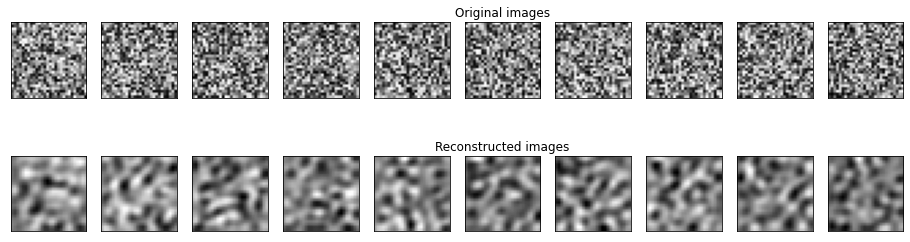

EPOCH 151/200 	 train loss 0.072913758456707 	 val loss 0.07289698719978333
EPOCH 152/200 	 train loss 0.07293854653835297 	 val loss 0.072886161506176
EPOCH 153/200 	 train loss 0.07294903695583344 	 val loss 0.07295623421669006
EPOCH 154/200 	 train loss 0.07293751090765 	 val loss 0.07297080755233765
EPOCH 155/200 	 train loss 0.07292409986257553 	 val loss 0.07292421907186508
EPOCH 156/200 	 train loss 0.07292579859495163 	 val loss 0.07291699200868607
EPOCH 157/200 	 train loss 0.07292842864990234 	 val loss 0.07293751835823059
EPOCH 158/200 	 train loss 0.07291749119758606 	 val loss 0.07289900630712509
EPOCH 159/200 	 train loss 0.07290501147508621 	 val loss 0.07291380316019058
EPOCH 160/200 	 train loss 0.07292568683624268 	 val loss 0.07294321060180664


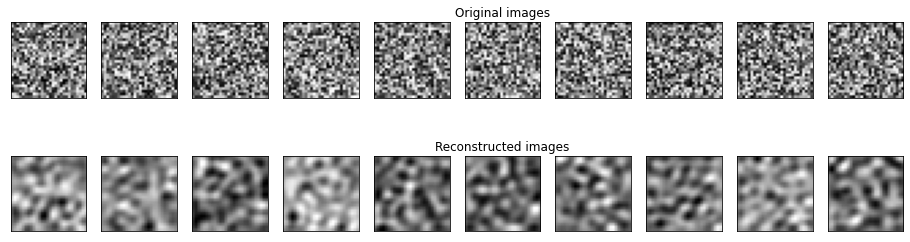

EPOCH 161/200 	 train loss 0.07295040786266327 	 val loss 0.07290990650653839
EPOCH 162/200 	 train loss 0.07290272414684296 	 val loss 0.07295779138803482
EPOCH 163/200 	 train loss 0.07292894273996353 	 val loss 0.07292688637971878
EPOCH 164/200 	 train loss 0.07291550189256668 	 val loss 0.0729173943400383
EPOCH 165/200 	 train loss 0.07292253524065018 	 val loss 0.0728861540555954
EPOCH 166/200 	 train loss 0.07294508069753647 	 val loss 0.07296133786439896
EPOCH 167/200 	 train loss 0.07292190194129944 	 val loss 0.07297549396753311
EPOCH 168/200 	 train loss 0.07292527705430984 	 val loss 0.07298120856285095
EPOCH 169/200 	 train loss 0.07294826954603195 	 val loss 0.07289235293865204
EPOCH 170/200 	 train loss 0.07290435582399368 	 val loss 0.07295352965593338


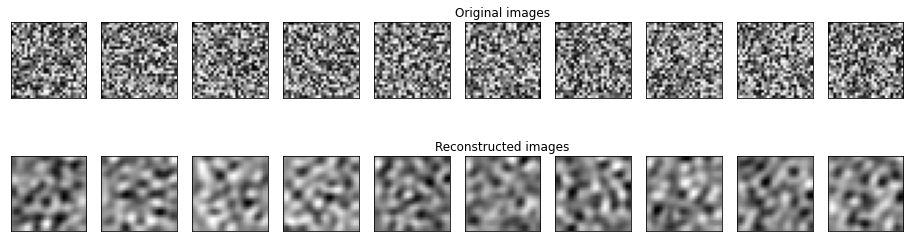

EPOCH 171/200 	 train loss 0.07293085008859634 	 val loss 0.07293086498975754
EPOCH 172/200 	 train loss 0.07291147857904434 	 val loss 0.07287168502807617
EPOCH 173/200 	 train loss 0.07291778922080994 	 val loss 0.07290156930685043
EPOCH 174/200 	 train loss 0.07292602956295013 	 val loss 0.07294527441263199
EPOCH 175/200 	 train loss 0.07291973382234573 	 val loss 0.07294832170009613
EPOCH 176/200 	 train loss 0.07293650507926941 	 val loss 0.07298062741756439
EPOCH 177/200 	 train loss 0.0729205384850502 	 val loss 0.07296634465456009
EPOCH 178/200 	 train loss 0.07290355116128922 	 val loss 0.07289279997348785
EPOCH 179/200 	 train loss 0.07291846722364426 	 val loss 0.07289749383926392
EPOCH 180/200 	 train loss 0.07292617857456207 	 val loss 0.07292359322309494


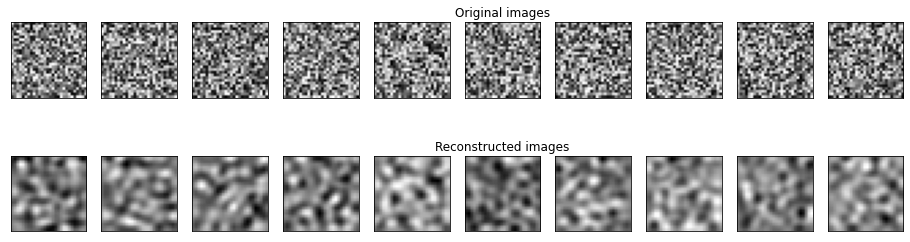

EPOCH 181/200 	 train loss 0.07293373346328735 	 val loss 0.07297009229660034
EPOCH 182/200 	 train loss 0.07292470335960388 	 val loss 0.07286495715379715
EPOCH 183/200 	 train loss 0.07290326058864594 	 val loss 0.07293841242790222
EPOCH 184/200 	 train loss 0.07292474806308746 	 val loss 0.07292182743549347
EPOCH 185/200 	 train loss 0.07291651517152786 	 val loss 0.07300391048192978
EPOCH 186/200 	 train loss 0.07290222495794296 	 val loss 0.07292687147855759
EPOCH 187/200 	 train loss 0.07293142378330231 	 val loss 0.07290337234735489
EPOCH 188/200 	 train loss 0.07293542474508286 	 val loss 0.07293708622455597
EPOCH 189/200 	 train loss 0.07293164730072021 	 val loss 0.0729355439543724
EPOCH 190/200 	 train loss 0.0729035809636116 	 val loss 0.07286090403795242


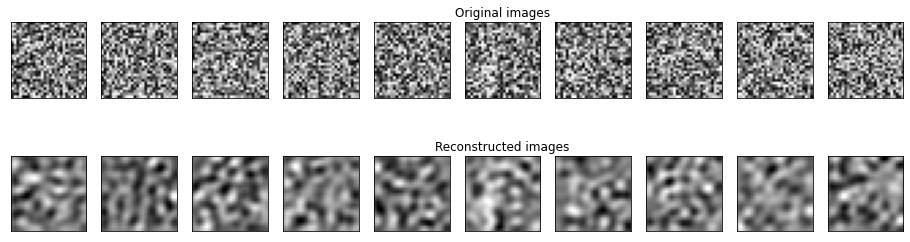

EPOCH 191/200 	 train loss 0.0729120671749115 	 val loss 0.07288390398025513
EPOCH 192/200 	 train loss 0.07293318957090378 	 val loss 0.07290376722812653
EPOCH 193/200 	 train loss 0.07291729003190994 	 val loss 0.0728955939412117
EPOCH 194/200 	 train loss 0.07293257117271423 	 val loss 0.07287785410881042
EPOCH 195/200 	 train loss 0.072929248213768 	 val loss 0.0729205310344696
EPOCH 196/200 	 train loss 0.0729374811053276 	 val loss 0.07287928462028503
EPOCH 197/200 	 train loss 0.07291501015424728 	 val loss 0.07290711253881454
EPOCH 198/200 	 train loss 0.07292062044143677 	 val loss 0.0729314461350441
EPOCH 199/200 	 train loss 0.0729454904794693 	 val loss 0.0729832723736763
EPOCH 200/200 	 train loss 0.07290463894605637 	 val loss 0.0729081928730011


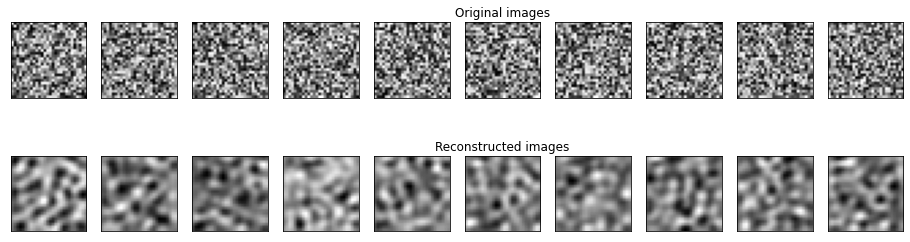

In [138]:
num_epochs = 200
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if (((epoch+1) % 10) == 0):
      plot_ae_outputs(encoder,decoder,n=10)

In [139]:
def plot_ae_outputs_mnist(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

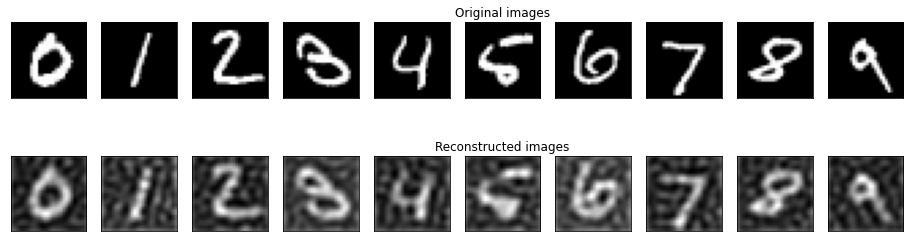

In [140]:
plot_ae_outputs_mnist(encoder, decoder, 10)